In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np

import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

# RNN Class definition

In [9]:
x=np.load('BTCUSD.npy')
print(x)
#
# 1 minute data
#
# x[:,0] = open
# x[:,1] = high
# x[:,2] = low
# x[:,3] = close
# x[:,4] = volume
keys = ['open', 'high', 'low', 'close', 'volume']

[[  54225.    54225.5   54171.5   54205.  2836315. ]
 [  54205.    54205.    54204.5   54204.5  437065. ]
 [  54204.5   54243.    54204.5   54234.5  750762. ]
 ...
 [  55081.5   55081.5   54933.5   55030.  7238913. ]
 [  55030.    55030.    54990.    55021.  1093417. ]
 [  55021.    55021.    55021.    55021.        0. ]]


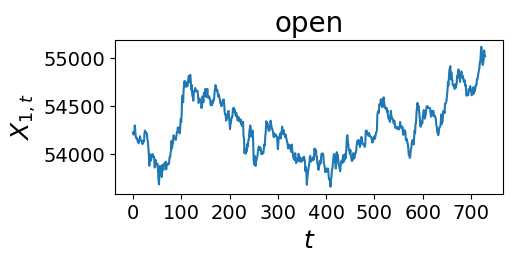

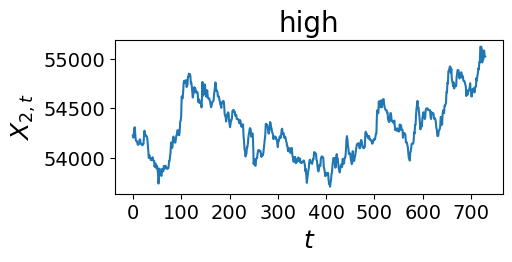

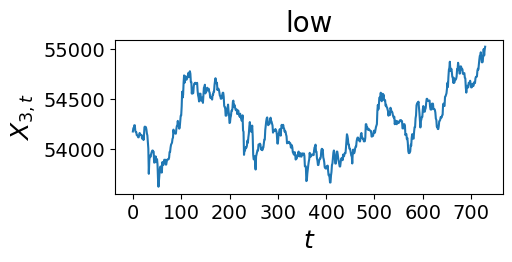

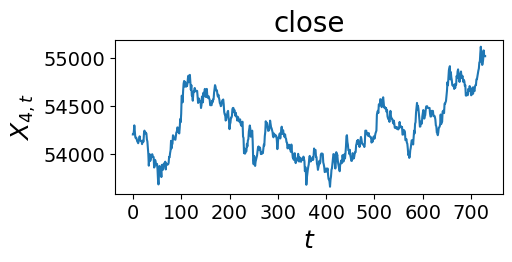

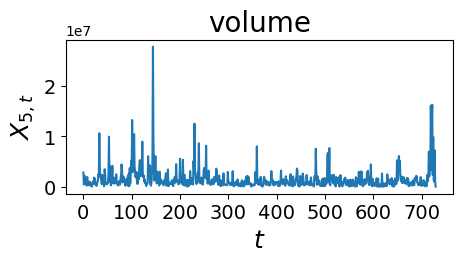

In [10]:
for i in range(x.shape[1]):
    fig = plt.figure(figsize=(5,2))
    plt.plot(x[:,i])
    plt.ylabel(r'$X_{' + str(i+1) +',t}$', fontsize=18)
    plt.xlabel(r'$t$', fontsize=18)
    plt.title(keys[i], fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

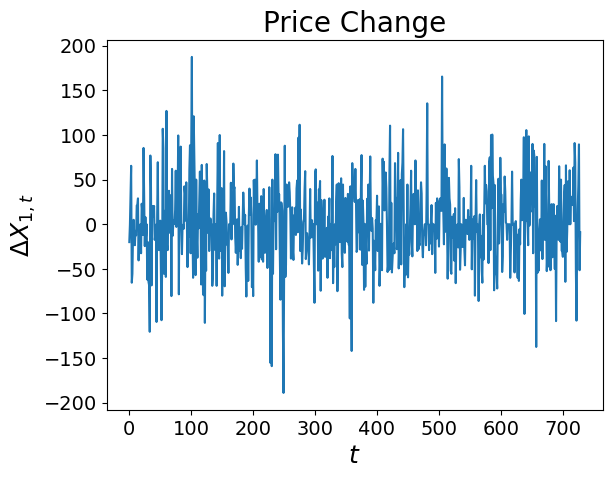

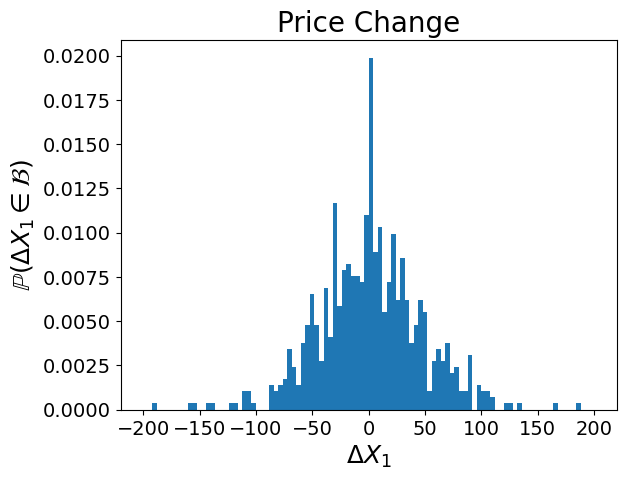

In [11]:

plt.plot(np.diff(x[:,0]))
plt.title('Price Change', fontsize=20)
plt.xlabel(r'$t$', fontsize=18)
plt.ylabel(r'$\Delta X_{1,t}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

plt.hist(np.diff(x[:,0]), bins=np.linspace(-200,200,101), density=True)
plt.title('Price Change', fontsize=20)
plt.xlabel(r'$\Delta X_{1}$', fontsize=18)
plt.ylabel(r'$\mathbb{P}(\Delta X_{1}\in\mathcal{B})$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [12]:
DX = np.diff(x[:,0])
print(np.mean(DX))
print(np.std(DX))

from scipy.stats import skew
print(skew(DX))

1.0919067215363512
45.38969115826414
0.0016008715026118701


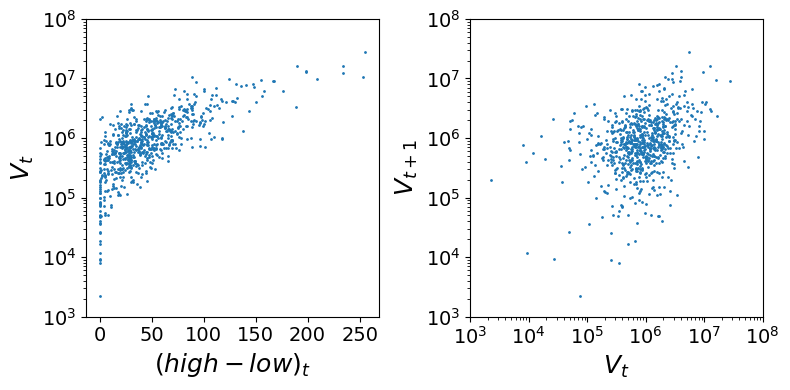

In [13]:
fig = plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(x[:,1]-x[:,2],x[:,-1],s=1)
plt.yscale('log')
plt.ylim(1e3,1e8)
plt.xlabel(r'$(high-low)_t$',fontsize=18)
plt.ylabel(r'$V_t$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,2,2)
plt.scatter(x[:-1,-1],x[1:,-1],s=1)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e3,1e8)
plt.xlim(1e3,1e8)
plt.xlabel(r'$V_t$',fontsize=18)
plt.ylabel(r'$V_{t+1}$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

In [14]:
# amalgamte the Volume data and one-step ahead
y = np.zeros((x.shape[0]-1,2))
y[:,0] = x[:-1,-1]
y[:,1] = x[1:,-1]

print(y.shape)

# remove rows where at least one of them is nan
mask = (np.sum(np.isnan(y), axis=1) > 0)
y = y[~mask,:]

print(y.shape)

(729, 2)
(729, 2)


In [15]:
corr = np.corrcoef(y.T)
print(corr)

[[1.         0.40114816]
 [0.40114816 1.        ]]


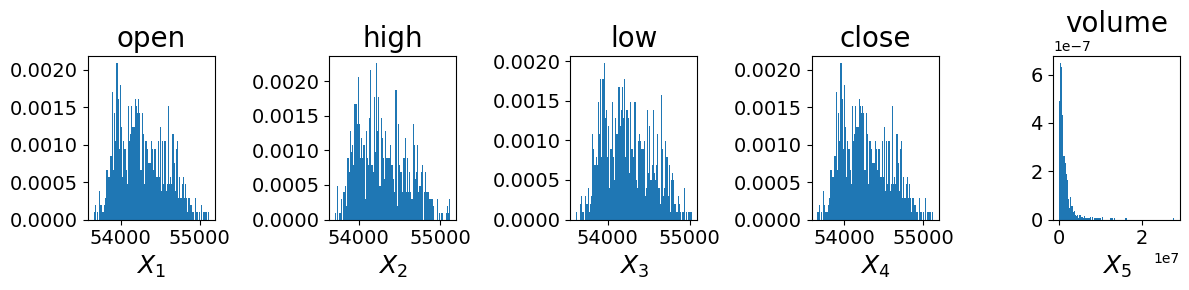

In [16]:
def PlotFeatures(x, rng=None):
    fig = plt.figure(figsize=(12,3))

    for i in range(x.shape[1]):

        plt.subplot(1,x.shape[1],i+1)
        plt.hist(x[:,i],bins=101, density=True)
        plt.xlabel(r'$X_'+str(i+1) + '$',fontsize=18)
        plt.title(keys[i],fontsize=20)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        if rng is not None:
            plt.xlim(rng)
        
    plt.tight_layout()
    plt.show()
    
PlotFeatures(x)

In [17]:
def NormalizeFeatures(x):
    
#     P( a X + b < -1) = 0.1 => P( X  < -(1+b)/a ) = 0.1 => (1+b) = -q_0.1 a
#     P( a X + b < 1) = 0.9 => P( X  < (1-b)/a ) = 0.9 => (1-b) = q_0.9 a
    
#     2 = a(q_0.9-q_0.1) => a = 2/(q_0.9 - q_0.1)
#     b = 1 - q_0.9 a
    
    y = copy.copy(x)
    
    # transform the volume data using log transform first
    y[:,-1] = np.log(1+y[:,-1]/np.quantile(y[:,-1],0.5))
    
    for i in range(x.shape[1]):
        
        qtl = np.quantile(y[:,i], [0.1,0.9])
        a = 2/(qtl[1]-qtl[0])
        b = 1 - qtl[1] * a
        
        y[:,i] = a*y[:,i] + b
        
    return y

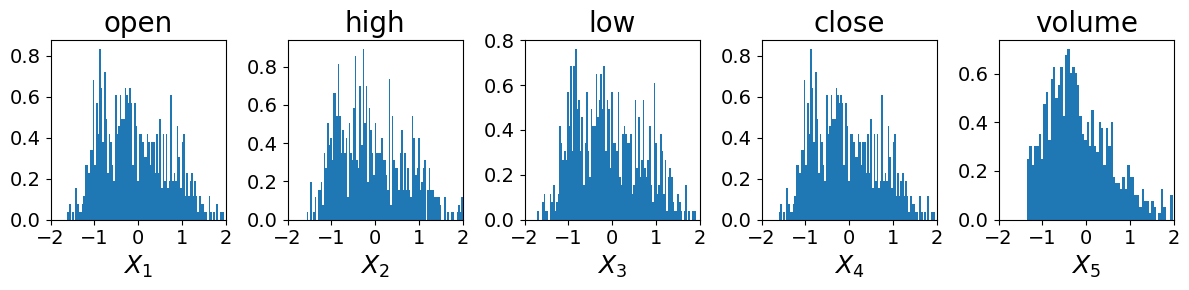

In [18]:
x_nrm = NormalizeFeatures(x)
PlotFeatures(x_nrm, [-2,2])

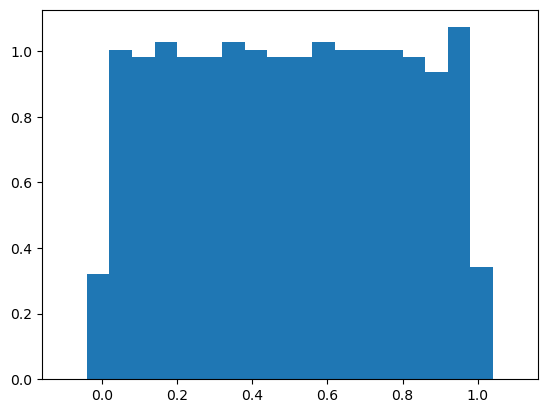

In [19]:
from statsmodels.distributions.empirical_distribution import ECDF
F = ECDF(x_nrm[:,0])
U = F(x_nrm[:,0])

plt.hist(U, bins=np.linspace(-0.1,1.1,21), density=True)
plt.show()

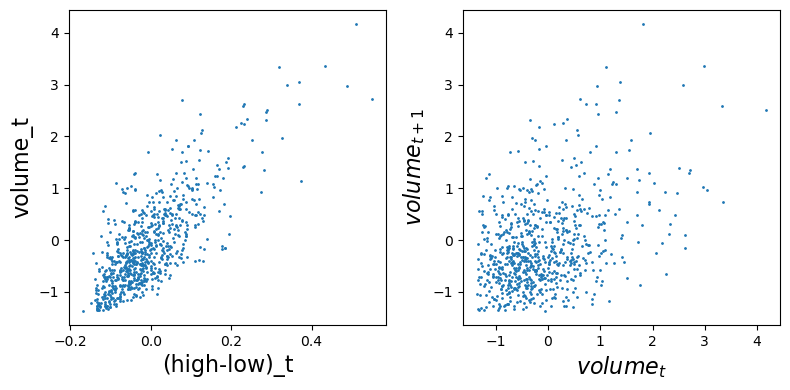

In [20]:
fig = plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(x_nrm[:,1]-x_nrm[:,2],x_nrm[:,-1],s=1)
plt.xlabel('(high-low)_t',fontsize=16)
plt.ylabel('volume_t',fontsize=16)

plt.subplot(1,2,2)
plt.scatter(x_nrm[:-1,-1],x_nrm[1:,-1],s=1)
plt.xlabel('$volume_t$',fontsize=16)
plt.ylabel('$volume_{t+1}$',fontsize=16)

plt.tight_layout()
plt.show()

In [21]:
class MyNet(nn.Module):
    
    def __init__(self, ni, hs, nl ):
        super(MyNet, self).__init__()
        
        # GRU layer
        self.GRU = nn.GRU(input_size=ni, hidden_size=hs, num_layers=nl)
        
        # GRU to output
        self.prop_h_to_out = nn.Linear(hs, 1)

    def forward(self, x):
        
        # input into  GRU layer (seq, batch, feature)
#         h_all, h_last = self.GRU(x)
        _, h_last = self.GRU(x)
        
        # GRU output to output layer
        y = self.prop_h_to_out(h_last)
        
        return y

In [22]:
x_nrm
print(x_nrm.shape)

(730, 5)


In [24]:
# def GrabBatch(t, n_series, x):
    
#     X = torch.zeros((n_series, len(t), x.shape[1]))
    
#     for i in range(len(t)):
#         X[:,i,:] = torch.tensor(x[t[i]:t[i]+n_series,:]).float()
    
#     return X

def CreateTimeSeriesSnippets(n_series, x):
    
    Y = torch.zeros((n_series, x.shape[0]-n_series, x.shape[1]))
    
    for i in range(x.shape[0]-n_series):
        Y[:,i,:] = torch.tensor(x[i:i+n_series,:]).float()
    
    return Y

Y = CreateTimeSeriesSnippets(10, x_nrm[:,-2:])
print(Y)
print(Y.shape)

tensor([[[-0.2525,  0.9393],
         [-0.2538, -0.7113],
         [-0.1787, -0.3696],
         ...,
         [ 1.6283,  2.0309],
         [ 1.6371,  1.1027],
         [ 1.8648,  3.3372]],

        [[-0.2538, -0.7113],
         [-0.1787, -0.3696],
         [-0.0148,  0.6135],
         ...,
         [ 1.6371,  1.1027],
         [ 1.8648,  3.3372],
         [ 2.0375,  2.5788]],

        [[-0.1787, -0.3696],
         [-0.0148,  0.6135],
         [-0.1787,  0.2885],
         ...,
         [ 1.8648,  3.3372],
         [ 2.0375,  2.5788],
         [ 1.9112,  2.9883]],

        ...,

        [[-0.3376, -0.9953],
         [-0.3727,  0.5039],
         [-0.4315, -0.4248],
         ...,
         [ 1.6071,  2.6194],
         [ 1.7172,  0.1051],
         [ 1.9412, -0.1668]],

        [[-0.3727,  0.5039],
         [-0.4315, -0.4248],
         [-0.4503, -0.8806],
         ...,
         [ 1.7172,  0.1051],
         [ 1.9412, -0.1668],
         [ 1.8123,  2.1741]],

        [[-0.4315, -0.4248],
       

In [25]:
print(Y[:,0,:])
print(Y[:,3,:])
print(Y[:,11,:])

tensor([[-0.2525,  0.9393],
        [-0.2538, -0.7113],
        [-0.1787, -0.3696],
        [-0.0148,  0.6135],
        [-0.1787,  0.2885],
        [-0.3176, -0.0668],
        [-0.3501, -0.7421],
        [-0.3376, -0.9953],
        [-0.3727,  0.5039],
        [-0.4315, -0.4248]])
tensor([[-0.0148,  0.6135],
        [-0.1787,  0.2885],
        [-0.3176, -0.0668],
        [-0.3501, -0.7421],
        [-0.3376, -0.9953],
        [-0.3727,  0.5039],
        [-0.4315, -0.4248],
        [-0.4503, -0.8806],
        [-0.4815, -0.2732],
        [-0.4290, -0.8866]])
tensor([[-0.4815, -0.2732],
        [-0.4290, -0.8866],
        [-0.3739, -0.1293],
        [-0.3013, -0.6477],
        [-0.4027, -0.5352],
        [-0.4115, -1.1800],
        [-0.4240, -1.0599],
        [-0.4240, -1.2759],
        [-0.5053, -0.2500],
        [-0.4478, -0.5754]])


In [26]:
idx = torch.randint(0, Y.shape[1], (3,))
print(idx)
print(Y[:,idx,:])

tensor([ 35, 490, 101])
tensor([[[-0.7706,  0.5991],
         [-0.2976, -1.0400],
         [ 0.7586,  3.0487]],

        [[-0.9421,  0.2862],
         [-0.3139, -1.1367],
         [ 0.7373,  0.9587]],

        [[-0.8908,  0.3893],
         [-0.3264, -0.9850],
         [ 0.5872,  1.1893]],

        [[-0.8407, -0.6126],
         [-0.3276, -1.0831],
         [ 0.8900,  1.3678]],

        [[-0.8182,  0.7169],
         [-0.4640, -0.3406],
         [ 1.0702,  2.7030]],

        [[-0.7669, -0.3774],
         [-0.4040,  0.2841],
         [ 1.1415,  1.3025]],

        [[-0.8107, -0.2482],
         [-0.4453, -1.1712],
         [ 0.9989,  1.0824]],

        [[-0.8407, -0.5940],
         [-0.3727,  0.0448],
         [ 1.1240,  0.4784]],

        [[-0.8419, -1.1923],
         [-0.3139, -0.3863],
         [ 1.0877,  0.9817]],

        [[-1.1160,  1.1926],
         [-0.3013,  0.3804],
         [ 0.9939,  0.4784]]])


In [27]:
net = MyNet(ni=2, hs=4, nl=6)

In [29]:
h_all, h_last = net.GRU(Y[:,idx,:])
print(Y[:,idx,:].shape)
print(h_all.shape)
print(h_all)
print("****")
print(h_last.shape)
print(h_last)


torch.Size([10, 3, 2])
torch.Size([10, 3, 4])
tensor([[[-0.1623, -0.0599, -0.0188,  0.1048],
         [-0.1635, -0.0600, -0.0192,  0.1044],
         [-0.1626, -0.0599, -0.0189,  0.1047]],

        [[-0.2783, -0.0736, -0.0385,  0.1843],
         [-0.2819, -0.0739, -0.0400,  0.1828],
         [-0.2805, -0.0736, -0.0394,  0.1836]],

        [[-0.3525, -0.0675, -0.0531,  0.2351],
         [-0.3590, -0.0685, -0.0563,  0.2318],
         [-0.3581, -0.0679, -0.0555,  0.2328]],

        [[-0.3975, -0.0558, -0.0629,  0.2654],
         [-0.4067, -0.0577, -0.0679,  0.2599],
         [-0.4073, -0.0569, -0.0676,  0.2605]],

        [[-0.4239, -0.0443, -0.0693,  0.2831],
         [-0.4355, -0.0473, -0.0763,  0.2757],
         [-0.4386, -0.0465, -0.0770,  0.2750]],

        [[-0.4396, -0.0351, -0.0738,  0.2935],
         [-0.4525, -0.0391, -0.0822,  0.2847],
         [-0.4593, -0.0387, -0.0848,  0.2819]],

        [[-0.4490, -0.0284, -0.0771,  0.2997],
         [-0.4627, -0.0332, -0.0866,  0.2900],
  

In [33]:
h_last.transpose(0,1)

tensor([[[ 0.6896, -0.4923, -0.1049,  0.1690],
         [ 0.2023, -0.0149, -0.0099,  0.4296],
         [-0.3654, -0.3059,  0.1643,  0.4075],
         [ 0.3028, -0.0443, -0.4106,  0.2006],
         [ 0.4757,  0.3473,  0.0759,  0.3129],
         [-0.1220,  0.4046,  0.1388,  0.1317]],

        [[ 0.4923, -0.4954,  0.6715,  0.4507],
         [ 0.4578, -0.2356, -0.1359,  0.3666],
         [-0.3238, -0.3404,  0.1734,  0.4393],
         [ 0.2578, -0.0323, -0.4322,  0.2586],
         [ 0.4562,  0.3159,  0.0420,  0.3164],
         [-0.1199,  0.3651,  0.1244,  0.1128]],

        [[ 0.0586, -0.2861,  0.0210,  0.1212],
         [-0.0258, -0.0787, -0.0401,  0.5564],
         [-0.3919, -0.1722,  0.1534,  0.3103],
         [ 0.3404, -0.0596, -0.3823,  0.1246],
         [ 0.4936,  0.3781,  0.1075,  0.3111],
         [-0.1257,  0.4308,  0.1468,  0.1417]]], grad_fn=<TransposeBackward0>)

In [34]:
h_last.transpose(0,1).flatten(1,2)

tensor([[ 0.6896, -0.4923, -0.1049,  0.1690,  0.2023, -0.0149, -0.0099,  0.4296,
         -0.3654, -0.3059,  0.1643,  0.4075,  0.3028, -0.0443, -0.4106,  0.2006,
          0.4757,  0.3473,  0.0759,  0.3129, -0.1220,  0.4046,  0.1388,  0.1317],
        [ 0.4923, -0.4954,  0.6715,  0.4507,  0.4578, -0.2356, -0.1359,  0.3666,
         -0.3238, -0.3404,  0.1734,  0.4393,  0.2578, -0.0323, -0.4322,  0.2586,
          0.4562,  0.3159,  0.0420,  0.3164, -0.1199,  0.3651,  0.1244,  0.1128],
        [ 0.0586, -0.2861,  0.0210,  0.1212, -0.0258, -0.0787, -0.0401,  0.5564,
         -0.3919, -0.1722,  0.1534,  0.3103,  0.3404, -0.0596, -0.3823,  0.1246,
          0.4936,  0.3781,  0.1075,  0.3111, -0.1257,  0.4308,  0.1468,  0.1417]],
       grad_fn=<UnsafeViewBackward0>)

In [30]:
net(Y[:,idx,:])

tensor([[[0.3736],
         [0.7125],
         [0.2693]],

        [[0.3407],
         [0.3631],
         [0.3927]],

        [[0.4171],
         [0.4490],
         [0.3247]],

        [[0.1345],
         [0.1490],
         [0.1137]],

        [[0.2236],
         [0.2235],
         [0.2240]],

        [[0.0848],
         [0.0836],
         [0.0837]]], grad_fn=<ViewBackward0>)

In [31]:
net(Y[:,idx,:]).shape

torch.Size([6, 3, 1])